In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('D:/Program Files/JupyterLabWorkspace/chess_data/full_labeled.csv')
data['moves'] = data['moves'].str.split()
data['marks'] = data['marks'].str.split(',').apply(lambda x: (int(x[0]), int(x[1])))
data.head()

,id,white_elo,black_elo,moves,marks
0,787zsVup,1638.0,1851.0,"[e2e4, c7c6, f2f4, d7d5, e4d5, c6d5, g1f3, b8c...","(47, 53)"
1,F8M8OS71,1760.0,1823.0,"[e2e4, c7c5, g1f3, d7d6, c2c3, g8f6, d2d3, a7a...","(52, 56)"
2,MQSyb3KW,1877.0,1909.0,"[e2e4, c7c5, c2c3, d7d6, d2d4, c5d4, c3d4, b7b...","(126, 130)"
3,4MWQCxQ6,1741.0,1625.0,"[e2e4, e7e5, d2d3, b8c6, g1f3, f8c5, f1e2, g8f...","(31, 35)"
4,e9AY2m5j,1766.0,1733.0,"[e2e4, c7c5, f1c4, e7e6, g1f3, d7d5, e4d5, e6d...","(49, 55)"


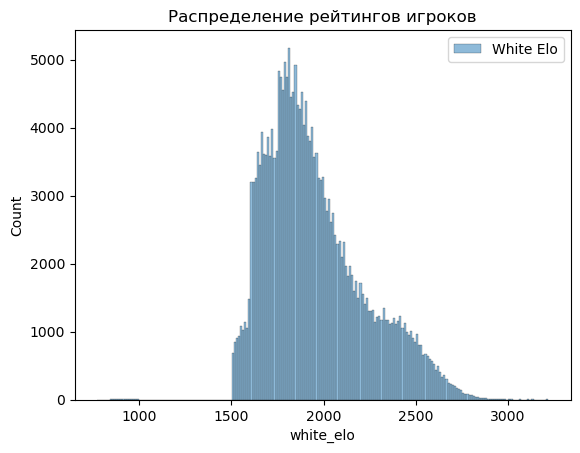

In [3]:
sns.histplot(data=data, x='white_elo', label='White Elo', alpha=0.5)
plt.title('Распределение рейтингов игроков')
plt.legend()
plt.show()

Партий с рейтингом от 1000 до 1500 почти нет. Причина, по которой lichess решил брать партии с рейтингом больше 1500 ясна, потому что у новичков игра очень сумбурная и интересных моментов там особо нет. Откуда правда взялись партии с рейтингом меньше 1000 - непонятно. Однако их немного и можно просто отсеять.

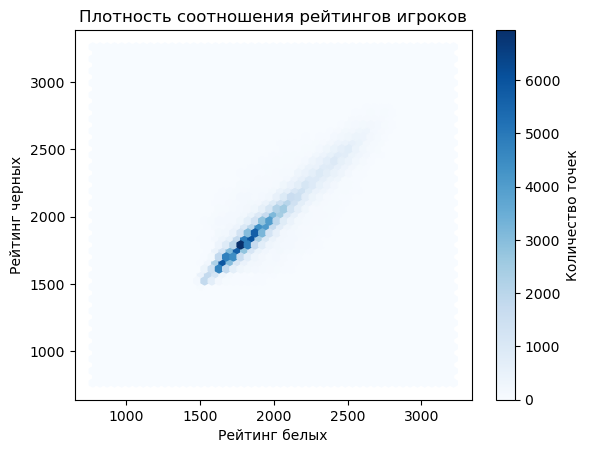

In [5]:
plt.hexbin(data['white_elo'], data['black_elo'], gridsize=50, cmap='Blues')
plt.colorbar(label='Количество точек')
plt.title('Плотность соотношения рейтингов игроков')
plt.xlabel('Рейтинг белых')
plt.ylabel('Рейтинг черных')
plt.show()

Как и ожидалось, рейтинги игроков достаточно близки друг к другу. Возможно, партии с большим разбросом рейтингов $(|white\_elo-black\_elo| > 500)$ также не содержат в себе полезной информации, потому что очевидно более сильный игрок выиграет. С другой стороны, если играют игроки с рейтингами 2000 и 2500, игрок с рейтингом 2000, в теории, по счастливому стечению обстоятельств, либо выиграет, либо будет играть очень достойно, что может оказаться интересным. К сожалению, ни первую, ни вторую гипотезу проверить не получится: такая оценка очень субъективна и автоматизировать процесс проверки этих гипотез не получится. Думаю, проще оставить все партии: модель будет увидит более реальные и полные данные.

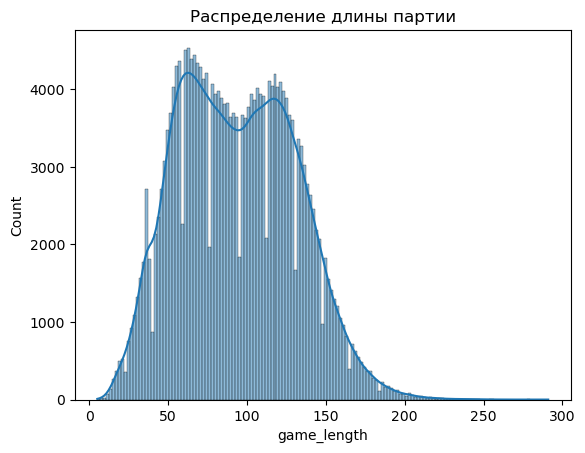

In [6]:
df = data

df['game_length'] = df['moves'].apply(len)
df['normalized_start'] = df.apply(lambda x: x['marks'][0] / x['game_length'], axis=1)
df['normalized_end'] = df.apply(lambda x: x['marks'][1] / x['game_length'], axis=1)

sns.histplot(df['game_length'], kde=True)
plt.title('Распределение длины партии')
plt.show()

Определим, в какой части партии чаще возникают интересные моменты.

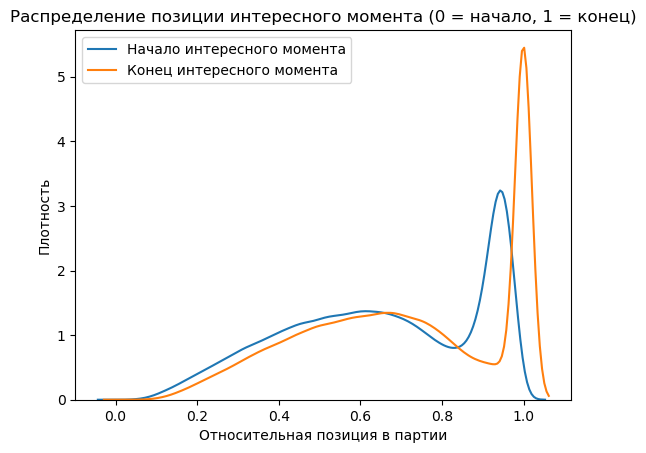

In [7]:
# Распределение нормализованной позиции начала интересного момента
sns.kdeplot(df['normalized_start'], label='Начало интересного момента')

# Распределение нормализованной позиции конца интересного момента
sns.kdeplot(df['normalized_end'], label='Конец интересного момента')

plt.title('Распределение позиции интересного момента (0 = начало, 1 = конец)')
plt.xlabel('Относительная позиция в партии')
plt.ylabel('Плотность')
plt.legend()
plt.show()

Достаточно логично, что многие интересные моменты выделяются ближе к концу партии. На протяжении всей игры шло развитие фигур, выигрыш материала, получение контроля, и всегда интересно посмотреть на развязку. Более того, очень много интересных моментов начинаются ближе к концу, а заканчивается последним ходом, то есть матом.

 Проверим, связаны ли напряжённые партии (близкие рейтинги) с большим количеством интересных моментов.

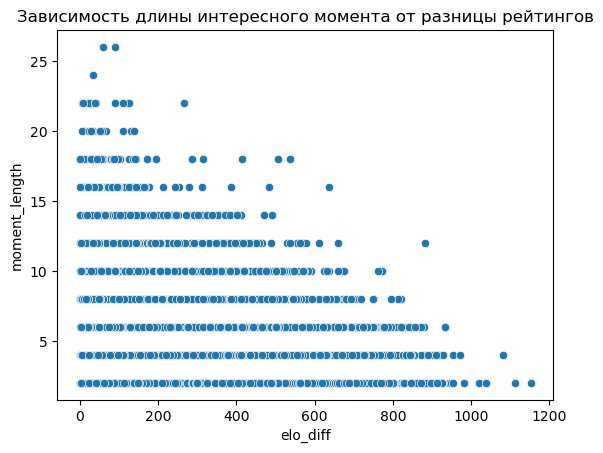

In [21]:
df['elo_diff'] = (df['white_elo'] - df['black_elo']).abs()
df['moment_length'] = df['marks'].apply(lambda x: x[1] - x[0])

sns.scatterplot(x='elo_diff', y='moment_length', data=df)
plt.title('Зависимость длины интересного момента от разницы рейтингов')
plt.show()

Как и было описано раньше, чем выше разрыв в рейтинге, тем очевиднее исход партии: победит игрок с более высоким рейтингом. Поэтому для партий с большим разрывом в рейтинге практически нету длинных интересных моментов (максимум небольшая связка для выигрыша преимущества). В случае маленького разрыва интересные моменты могут быть самыми разными

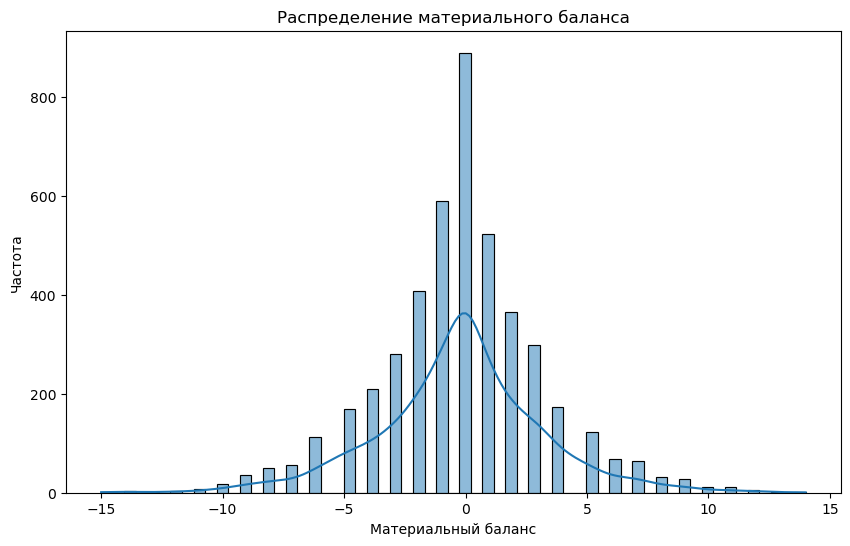

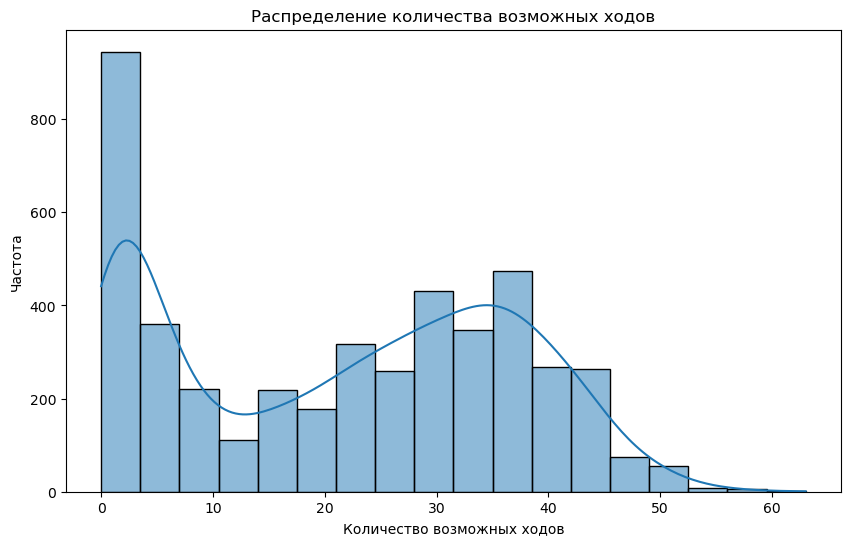

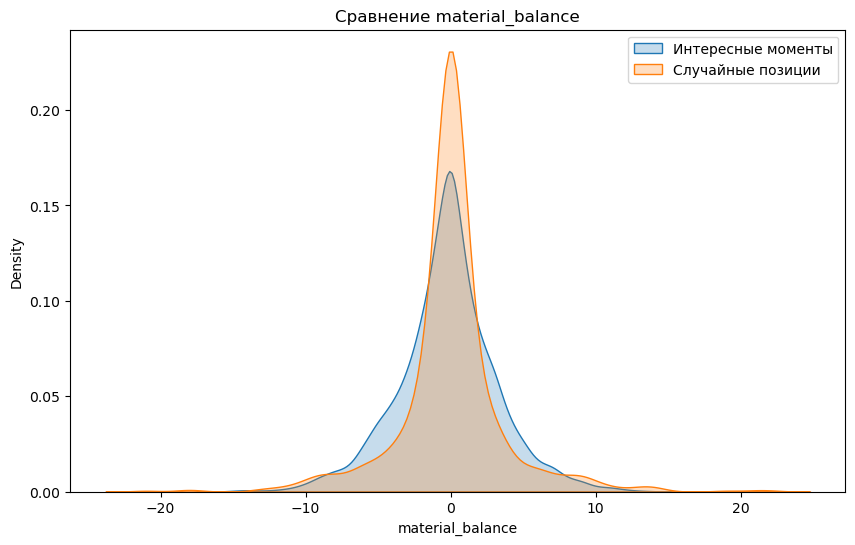

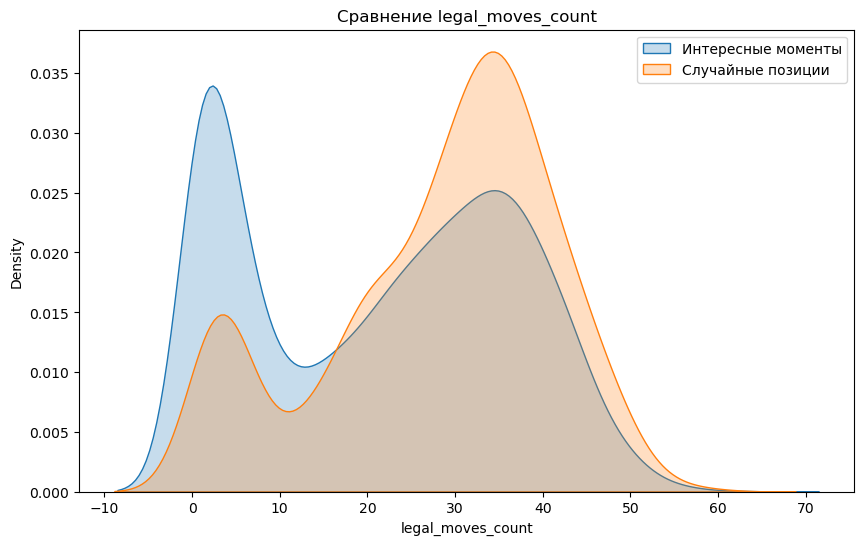

In [56]:
import pandas as pd
import numpy as np
import chess
import chess.svg
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter

# Загрузка данных (замените на ваш датасет)
# Предположим, что данные уже загружены в DataFrame df
# df = pd.read_csv('your_dataset.csv')

# Пример структуры данных:
# df = pd.DataFrame({
#     'id': [1, 2],
#     'white_elo': [1500, 1600],
#     'black_elo': [1400, 1550],
#     'moves': [['e2e4', 'e7e5'], ['d2d4', 'd7d5']],
#     'marks': [[3, 8], [4, 9]]
# })

# Шаг 1: Извлечение признаков из позиций
def extract_board_features(board):
    """
    Извлекает числовые признаки из состояния доски.
    """
    PIECE_VALUES = {
        chess.PAWN: 1,
        chess.KNIGHT: 3,
        chess.BISHOP: 3,
        chess.ROOK: 5,
        chess.QUEEN: 9,
        chess.KING: 0
    }
    
    features = {
        'white_pawns': len(board.pieces(chess.PAWN, chess.WHITE)),
        'black_pawns': len(board.pieces(chess.PAWN, chess.BLACK)),
        'white_knights': len(board.pieces(chess.KNIGHT, chess.WHITE)),
        'black_knights': len(board.pieces(chess.KNIGHT, chess.BLACK)),
        'white_bishops': len(board.pieces(chess.BISHOP, chess.WHITE)),
        'black_bishops': len(board.pieces(chess.BISHOP, chess.BLACK)),
        'white_rooks': len(board.pieces(chess.ROOK, chess.WHITE)),
        'black_rooks': len(board.pieces(chess.ROOK, chess.BLACK)),
        'white_queens': len(board.pieces(chess.QUEEN, chess.WHITE)),
        'black_queens': len(board.pieces(chess.QUEEN, chess.BLACK)),
        'material_balance': sum([PIECE_VALUES[piece] * len(board.pieces(piece, chess.WHITE)) for piece in PIECE_VALUES]) -
                            sum([PIECE_VALUES[piece] * len(board.pieces(piece, chess.BLACK)) for piece in PIECE_VALUES]),
        'is_check': board.is_check(),
        'checkers_count': len(board.checkers()),
        'legal_moves_count': board.legal_moves.count()
    }
    return features

def get_interesting_positions(row):
    """
    Возвращает список FEN-строк для интересных позиций.
    """
    moves = row['moves']
    start, end = row['marks']
    board = chess.Board()
    positions = []
    for i, move in enumerate(moves[:end]):
        board.push_uci(move)
        if start <= i < end:
            positions.append(board.fen())
    return positions


# Шаг 2: Извлечение интересных позиций
mini_df = df.head(1000).copy()
mini_df['interesting_positions'] = mini_df.apply(get_interesting_positions, axis=1)

# Шаг 3: Извлечение признаков для каждой позиции
all_features = []
for _, row in mini_df.iterrows():
    for fen in row['interesting_positions']:
        board = chess.Board(fen)
        features = extract_board_features(board)
        features['fen'] = fen  # Сохраняем FEN для отладки
        all_features.append(features)

features_df = pd.DataFrame(all_features)

# Шаг 4: Анализ признаков
# Распределение материального баланса
plt.figure(figsize=(10, 6))
sns.histplot(features_df['material_balance'], kde=True)
plt.title('Распределение материального баланса')
plt.xlabel('Материальный баланс')
plt.ylabel('Частота')
plt.show()

# Распределение количества возможных ходов
plt.figure(figsize=(10, 6))
sns.histplot(features_df['legal_moves_count'], kde=True)
plt.title('Распределение количества возможных ходов')
plt.xlabel('Количество возможных ходов')
plt.ylabel('Частота')
plt.show()


# Шаг 7: Сравнение с "обычными" позициями
def get_random_position(game_moves):
    """
    Возвращает случайную позицию из партии.
    """
    random_move_index = np.random.randint(0, len(game_moves) - 1)  # Избегаем начала и конца
    board = chess.Board()
    for move in game_moves[:random_move_index]:
        board.push_uci(move)
    return board


# Извлечение признаков для случайных позиций
random_features = []
for moves in mini_df['moves']:
    board = get_random_position(moves)
    random_features.append(extract_board_features(board))

random_df = pd.DataFrame(random_features)

# Сравнение распределений
for feature in ['material_balance', 'legal_moves_count']:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(features_df[feature], label='Интересные моменты', fill=True)
    sns.kdeplot(random_df[feature], label='Случайные позиции', fill=True)
    plt.title(f'Сравнение {feature}')
    plt.legend()
    plt.show()

Какие выводы из всего этого можно сделать? Во-первых, интересный момент, так или иначе, это наличие некоторого преимущества, скрытого потенциала, который нужно раскрыть (в этом и заключается интересность). Во-вторых, чем меньше возможных ходов можно сделать, тем меньше зрителю нужно что-либо просчитывать. При этом, если просчитывать нужно мало, а примущество можно получить значительное, это вызывает внутри приятное чувство собственной гениальности, такое же, как в случае, когда справился со сложной олимпиадной задачкой

Поэтому модель должна научиться находить такие паттерны и правильно выделять именно интересные, а не просто сложные или успешные ходы.